<a href="https://colab.research.google.com/github/ayyucedemirbas/multi_omics_BRCA_TCGA/blob/main/multi_omics_contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [2]:
class GraphNeuralLayer(layers.Layer):
    def __init__(self, units, activation='relu', use_bias=True, **kwargs):
        super(GraphNeuralLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias

    def build(self, input_shape):
        # input_shape: [(batch, nodes, features), (batch, nodes, nodes)]
        feature_dim = input_shape[0][-1]

        # Message passing weights
        self.W_msg = self.add_weight(
            name='W_msg',
            shape=(feature_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        # Self-connection weights
        self.W_self = self.add_weight(
            name='W_self',
            shape=(feature_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.units,),
                initializer='zeros',
                trainable=True
            )

        super(GraphNeuralLayer, self).build(input_shape)

    def call(self, inputs):
        features, adjacency = inputs

        # Self-connection: process own features
        self_output = tf.matmul(features, self.W_self)

        # Message passing: aggregate neighbor information
        neighbor_messages = tf.matmul(features, self.W_msg)
        aggregated = tf.matmul(adjacency, neighbor_messages)

        # Combine self and neighbor information
        output = self_output + aggregated

        if self.use_bias:
            output = tf.nn.bias_add(output, self.bias)

        return self.activation(output)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias
        }
        base_config = super(GraphNeuralLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
def load_and_preprocess_data():
    try:
        df = pd.read_csv('data.csv')
        print(f"Shape: {df.shape}")

        print(f"Missing values per column: {df.isnull().sum().sum()}")
        if df.isnull().sum().sum() > 0:
            # Fill missing values with median for numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
            print("Missing values filled with median")

        # Check if labels exist for optional fine-tuning
        has_labels = 'vital.status' in df.columns

        if has_labels:
            unique_values = df['vital.status'].unique()
            print(f"Unique vital.status values: {unique_values}")

            if set(unique_values).issubset({0, 1}):
                pass  # Already binary
            elif set(unique_values).issubset({'Alive', 'Dead', 'alive', 'dead'}):
                df['vital.status'] = df['vital.status'].str.lower().map({'alive': 0, 'dead': 1})
            elif set(unique_values).issubset({'Living', 'Deceased', 'living', 'deceased'}):
                df['vital.status'] = df['vital.status'].str.lower().map({'living': 0, 'deceased': 1})
            else:
                le = LabelEncoder()
                df['vital.status'] = le.fit_transform(df['vital.status'])
                print(f"Label encoding applied: {dict(zip(le.classes_, le.transform(le.classes_)))}")

            print("Initial label distribution:")
            label_counts = df["vital.status"].value_counts()
            print(label_counts)

            df_majority = df[df["vital.status"] == 0]
            df_minority = df[df["vital.status"] == 1]

            # Upsample minority class
            df_minority_upsampled = resample(df_minority,
                                             replace=True,
                                             n_samples=len(df_majority),
                                             random_state=42)

            df_balanced = pd.concat([df_majority, df_minority_upsampled])

            print("After upsampling:")
            label_counts_upsampled = df_balanced["vital.status"].value_counts()
            print(label_counts_upsampled)
        else:
            # For self-supervised learning, we don't need labels
            df_balanced = df
            print("No labels found")

        rna_cols = [col for col in df_balanced.columns if col.startswith('rs_')]
        cn_cols = [col for col in df_balanced.columns if col.startswith('cn_')]
        mu_cols = [col for col in df_balanced.columns if col.startswith('mu_')]
        pp_cols = [col for col in df_balanced.columns if col.startswith('pp_')]

        print(f"Feature distribution:")
        print(f"  RNA-seq (rs_): {len(rna_cols)}")
        print(f"  Copy Number (cn_): {len(cn_cols)}")
        print(f"  Mutation (mu_): {len(mu_cols)}")
        print(f"  Protein (pp_): {len(pp_cols)}")

        return df_balanced, has_labels

    except FileNotFoundError:
        print("Error: data.csv file not found.")
        return None, False
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, False

In [4]:
def create_adjacency_matrix(X, method='correlation', threshold=0.7, k_neighbors=10, max_features=200):
    # Reduce feature space to prevent memory issues
    if X.shape[1] > max_features:
        print(f"Reducing features from {X.shape[1]} to {max_features} using variance selection...")
        from sklearn.feature_selection import VarianceThreshold
        selector = VarianceThreshold(threshold=0.01)
        X_reduced = selector.fit_transform(X)

        if X_reduced.shape[1] > max_features:
            # Just take top variance features
            variances = np.var(X, axis=0)
            top_indices = np.argsort(variances)[-max_features:]
            X_reduced = X[:, top_indices]
            feature_indices = top_indices
        else:
            feature_indices = np.arange(X_reduced.shape[1])

        print(f"Final feature count: {X_reduced.shape[1]}")
    else:
        X_reduced = X
        feature_indices = np.arange(X.shape[1])

    n_features = X_reduced.shape[1]

    if method == 'correlation':
        corr_matrix = np.corrcoef(X_reduced.T)
        corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)
        adj_matrix = (np.abs(corr_matrix) > threshold).astype(np.float32)

    else:  # knn method
        from sklearn.neighbors import kneighbors_graph
        adj_matrix = kneighbors_graph(X_reduced.T, n_neighbors=min(k_neighbors, n_features//4),
                                    mode='connectivity', include_self=False)
        adj_matrix = adj_matrix.toarray().astype(np.float32)
        adj_matrix = (adj_matrix + adj_matrix.T) / 2

    adj_matrix += np.eye(n_features, dtype=np.float32)

    degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
    degree_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(degree_matrix) + 1e-6))
    adj_normalized = degree_inv_sqrt @ adj_matrix @ degree_inv_sqrt

    print(f"Adjacency matrix shape: {adj_normalized.shape}")
    print(f"Number of edges: {np.sum(adj_matrix > 0) // 2}")

    return adj_normalized.astype(np.float32), X_reduced.astype(np.float32), feature_indices

In [5]:
def visualize_data(df, adj_matrix, has_labels=True):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    if has_labels:
        axes[0, 0].pie(df['vital.status'].value_counts(),
                       labels=['Alive', 'Deceased'], autopct='%1.1f%%')
        axes[0, 0].set_title('Class Distribution')
    else:
        axes[0, 0].text(0.5, 0.5, 'No labels available\n(Self-supervised only)',
                       ha='center', va='center', fontsize=12)
        axes[0, 0].set_title('Class Distribution')

    rna_cols = [col for col in df.columns if col.startswith('rs_')]
    cn_cols = [col for col in df.columns if col.startswith('cn_')]
    mu_cols = [col for col in df.columns if col.startswith('mu_')]
    pp_cols = [col for col in df.columns if col.startswith('pp_')]

    feature_counts = [len(rna_cols), len(cn_cols), len(mu_cols), len(pp_cols)]
    axes[0, 1].bar(['RNA-seq', 'Copy Number', 'Mutation', 'Protein'], feature_counts)
    axes[0, 1].set_title('Feature Types Distribution')
    axes[0, 1].set_ylabel('Number of Features')

    if len(rna_cols) > 0:
        sample_features = df[rna_cols[:10]].values
        if has_labels:
            axes[0, 2].boxplot([sample_features[df['vital.status'] == 0].flatten(),
                                sample_features[df['vital.status'] == 1].flatten()],
                               labels=['Alive', 'Deceased'])
            axes[0, 2].set_title('Sample RNA-seq Features by Class')
        else:
            axes[0, 2].boxplot(sample_features.flatten())
            axes[0, 2].set_title('Sample RNA-seq Features Distribution')
        axes[0, 2].set_ylabel('Expression Level')
    else:
        axes[0, 2].text(0.5, 0.5, 'No RNA-seq features found', ha='center', va='center')

    sample_adj = adj_matrix[:50, :50]  # Show subset for visibility
    sns.heatmap(sample_adj, cmap='viridis', ax=axes[1, 0])
    axes[1, 0].set_title('Adjacency Matrix (50x50 subset)')

    degrees = np.sum(adj_matrix > 0, axis=1)
    axes[1, 1].hist(degrees, bins=30, alpha=0.7)
    axes[1, 1].set_title('Node Degree Distribution')
    axes[1, 1].set_xlabel('Degree')
    axes[1, 1].set_ylabel('Frequency')

    if has_labels:
        features = df.drop('vital.status', axis=1).values
    else:
        features = df.values

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)

    if has_labels:
        colors = ['blue' if x == 0 else 'red' for x in df['vital.status']]
        axes[1, 2].scatter(features_pca[:, 0], features_pca[:, 1], c=colors, alpha=0.6)
    else:
        axes[1, 2].scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.6)

    axes[1, 2].set_title(f'PCA Visualization\n(Explained variance: {pca.explained_variance_ratio_.sum():.3f})')
    axes[1, 2].set_xlabel('First Principal Component')
    axes[1, 2].set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()

In [6]:
def build_gnn_encoder(n_features, latent_dim=128):
    feature_input = keras.Input(shape=(n_features, 1), name='features')
    adjacency_input = keras.Input(shape=(n_features, n_features), name='adjacency')

    x = GraphNeuralLayer(512, activation='relu')([feature_input, adjacency_input])
    x = layers.Dropout(0.2)(x)

    x = GraphNeuralLayer(256, activation='relu')([x, adjacency_input])
    x = layers.Dropout(0.2)(x)

    x = GraphNeuralLayer(latent_dim, activation='relu')([x, adjacency_input])
    x = layers.Dropout(0.2)(x)

    graph_representation = layers.GlobalAveragePooling1D()(x)

    encoder = keras.Model(inputs=[feature_input, adjacency_input], outputs=graph_representation)
    return encoder

In [7]:
def build_projection_head(latent_dim=128, output_dim=64):
    model = keras.Sequential([
        layers.Dense(latent_dim, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(output_dim, activation=None)
    ])
    return model

In [8]:
class ContrastiveModel(keras.Model):
    def __init__(self, encoder, projection_head, temperature=0.1, **kwargs):
        super(ContrastiveModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.projection_head = projection_head
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, inputs):
        features_1, adjacency_1, features_2, adjacency_2 = inputs

        h_i = self.encoder([features_1, adjacency_1])
        h_j = self.encoder([features_2, adjacency_2])

        z_i = self.projection_head(h_i)
        z_j = self.projection_head(h_j)

        return z_i, z_j

    def compute_loss(self, z_i, z_j):
        z_i = tf.math.l2_normalize(z_i, axis=1)
        z_j = tf.math.l2_normalize(z_j, axis=1)

        similarities = tf.matmul(z_i, z_j, transpose_b=True) / self.temperature

        batch_size = tf.shape(z_i)[0]
        labels = tf.range(batch_size)

        loss_i = keras.losses.sparse_categorical_crossentropy(
            labels, similarities, from_logits=True)
        loss_j = keras.losses.sparse_categorical_crossentropy(
            labels, tf.transpose(similarities), from_logits=True)

        loss = tf.reduce_mean(loss_i + loss_j) / 2
        return loss

    def train_step(self, data):
        features_1, adjacency_1, features_2, adjacency_2 = data

        with tf.GradientTape() as tape:
            z_i, z_j = self([features_1, adjacency_1, features_2, adjacency_2])

            loss = self.compute_loss(z_i, z_j)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

In [9]:
def build_downstream_classifier(encoder, num_classes=2):
    encoder.trainable = True

    features_input = keras.Input(shape=encoder.input[0].shape[1:], name='features')
    adjacency_input = keras.Input(shape=encoder.input[1].shape[1:], name='adjacency')

    representation = encoder([features_input, adjacency_input])

    x = layers.Dense(64, activation='relu')(representation)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[features_input, adjacency_input], outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
def prepare_graph_data(X, adj_matrix):
    X_graph = X.reshape(X.shape[0], X.shape[1], 1)

    batch_size = X.shape[0]
    adj_batch = np.tile(adj_matrix[np.newaxis, :, :], (batch_size, 1, 1))

    return X_graph, adj_batch

In [11]:
def create_contrastive_dataset(X, adj_matrix, corruption_rate=0.2, batch_size=32):
    X_graph, adj_batch = prepare_graph_data(X, adj_matrix)

    X_corrupted = X_graph.copy()
    mask = np.random.random(X_corrupted.shape) < corruption_rate
    noise = np.random.normal(0, 0.1, X_corrupted.shape)
    X_corrupted[mask] += noise[mask]

    dataset = tf.data.Dataset.from_tensor_slices((
        X_graph, adj_batch, X_corrupted, adj_batch
    ))

    dataset = dataset.shuffle(1000).batch(batch_size)

    return dataset

In [12]:
def train_contrastive_model(contrastive_model, X, adj_matrix, epochs=50, batch_size=32):
    dataset = create_contrastive_dataset(X, adj_matrix, batch_size=batch_size)

    history = contrastive_model.fit(
        dataset,
        epochs=epochs,
        verbose=1
    )

    return history

In [13]:
def train_downstream_classifier(classifier, X_train, y_train, adj_matrix,
                               X_val=None, y_val=None, epochs=30, batch_size=16):
    X_train_graph, adj_train_batch = prepare_graph_data(X_train, adj_matrix)

    validation_data = None
    if X_val is not None and y_val is not None:
        X_val_graph, adj_val_batch = prepare_graph_data(X_val, adj_matrix)
        validation_data = ([X_val_graph, adj_val_batch], y_val)

    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]

    history = classifier.fit(
        [X_train_graph, adj_train_batch],
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_data,
        callbacks=callbacks,
        verbose=1
    )

    return history

In [14]:
def evaluate_model(model, X_test, adj_matrix, y_test):
    X_test_graph, adj_test_batch = prepare_graph_data(X_test, adj_matrix)

    y_pred_proba = model.predict([X_test_graph, adj_test_batch])
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, y_pred_proba, y_pred

In [15]:
def plot_contrastive_results(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Contrastive Learning Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [16]:
def plot_downstream_results(history, y_test, y_pred_proba, y_pred):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Alive', 'Deceased'],
                yticklabels=['Alive', 'Deceased'],
                ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    axes[1, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [17]:
df, has_labels = load_and_preprocess_data()

Shape: (705, 1937)
Missing values per column: 0
Unique vital.status values: [0 1]
Initial label distribution:
vital.status
0    611
1     94
Name: count, dtype: int64
After upsampling:
vital.status
0    611
1    611
Name: count, dtype: int64
Feature distribution:
  RNA-seq (rs_): 604
  Copy Number (cn_): 860
  Mutation (mu_): 249
  Protein (pp_): 223


In [18]:
if has_labels:
    X = df.drop(columns=["vital.status"]).values.astype(np.float32)
    y = df["vital.status"].values.astype(np.float32)
else:
    X = df.values.astype(np.float32)
    y = None

In [19]:
feature_names = df.columns.tolist() if not has_labels else df.drop(columns=["vital.status"]).columns.tolist()

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

adj_matrix, X_reduced, feature_indices = create_adjacency_matrix(
    X_scaled, method='correlation', threshold=0.3, max_features=500
)

Reducing features from 1936 to 500 using variance selection...
Final feature count: 500
Adjacency matrix shape: (500, 500)
Number of edges: 6018


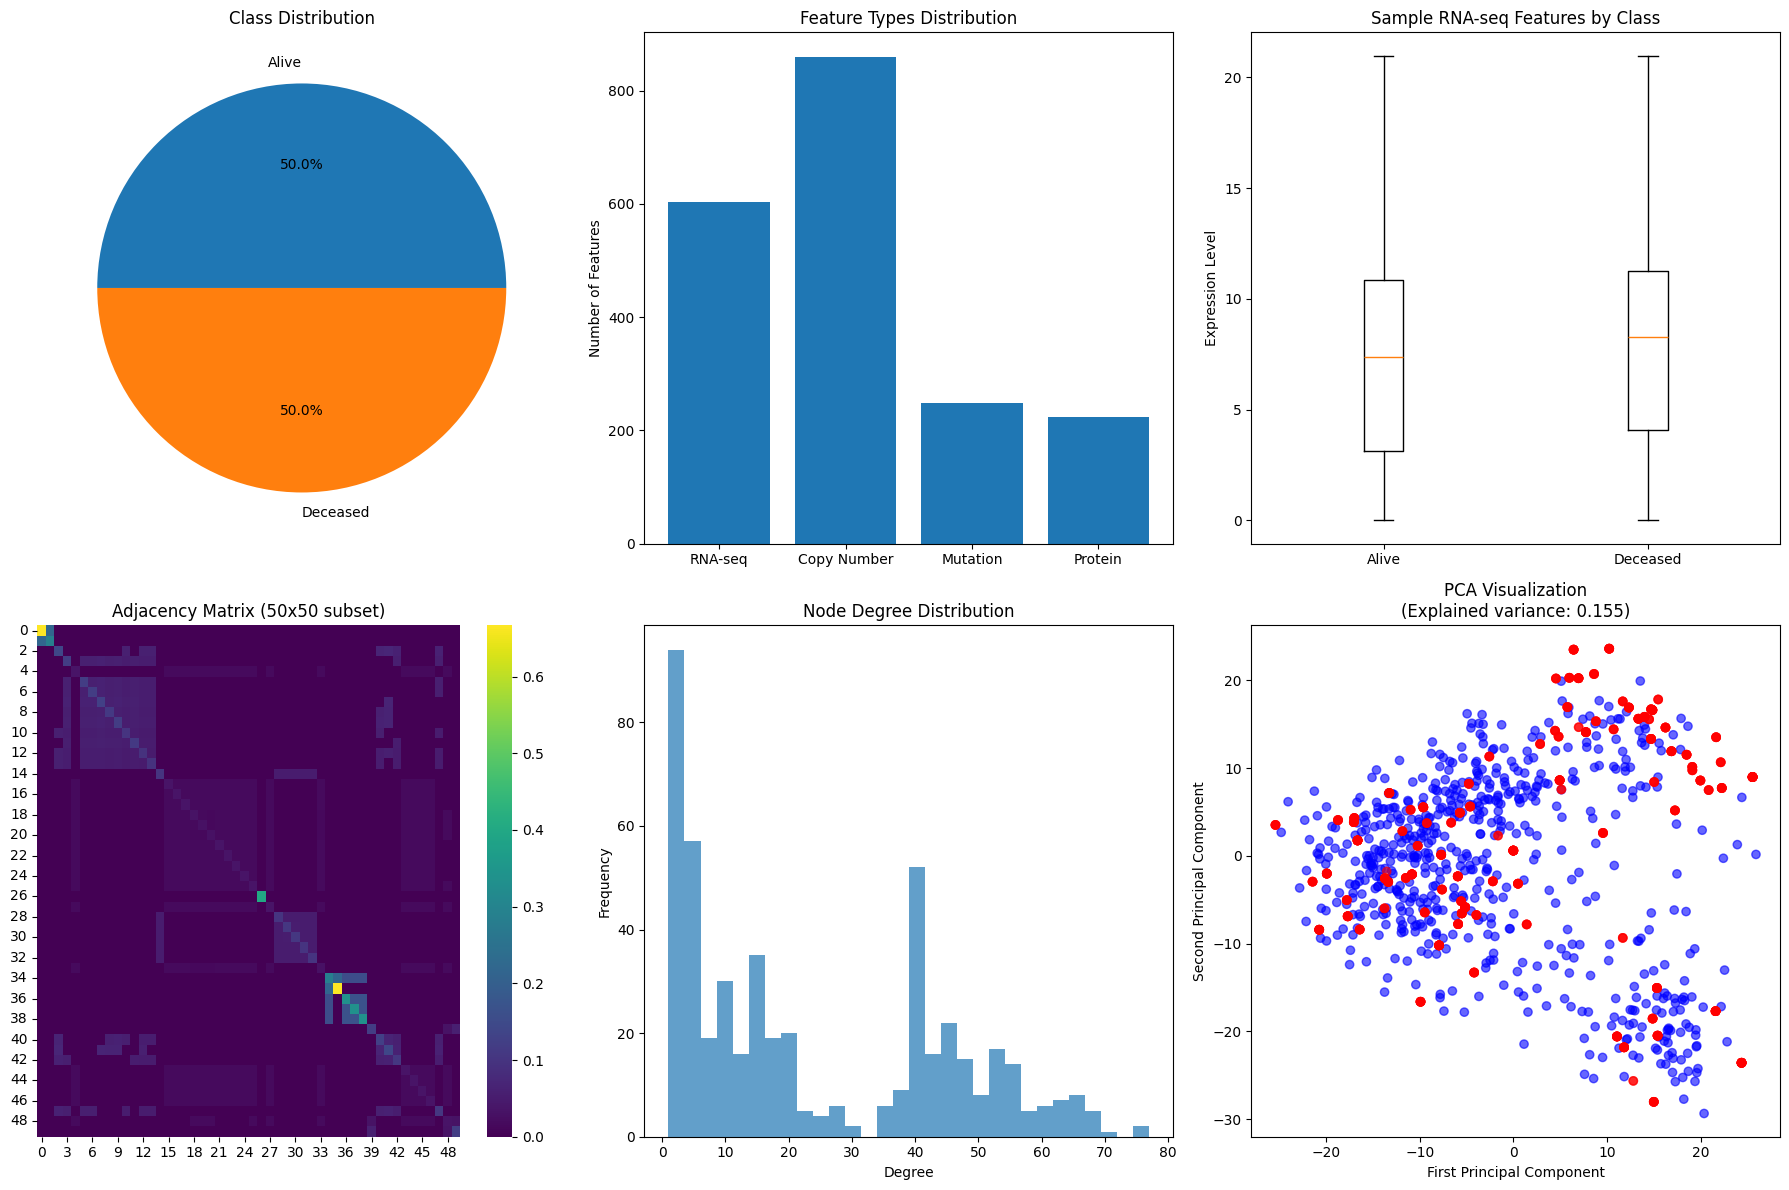

In [21]:
visualize_data(df, adj_matrix, has_labels)

In [22]:
encoder = build_gnn_encoder(n_features=X_reduced.shape[1], latent_dim=128)
projection_head = build_projection_head(latent_dim=128, output_dim=64)
contrastive_model = ContrastiveModel(encoder, projection_head, temperature=0.1)

In [23]:
contrastive_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [24]:
history = train_contrastive_model(
        contrastive_model, X_reduced, adj_matrix, epochs=50, batch_size=32
    )

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 1.6653
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.5082
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.2999
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.2165
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1842
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.1635
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1250
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.1278
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.1198
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.1286
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.1113
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1190
Epoch 13/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.1079
Epoch 14/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1145
Epoch 15/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0958
Ep

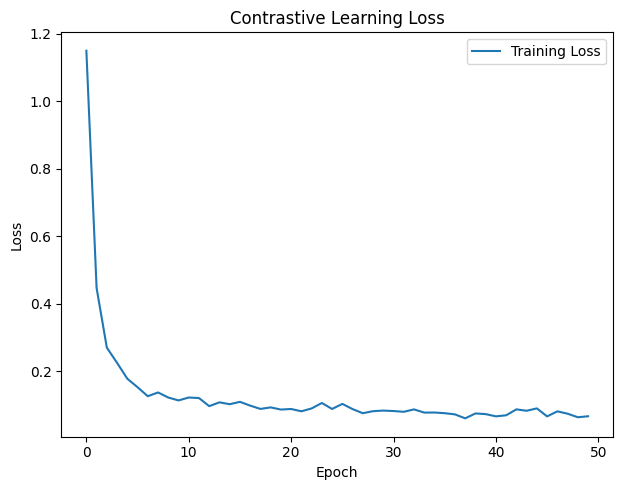

In [25]:
plot_contrastive_results(history)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.5077 - loss: 0.6963 - val_accuracy: 0.5551 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5199 - loss: 0.6909 - val_accuracy: 0.5429 - val_loss: 0.6841 - learning_rate: 0.0010
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5287 - loss: 0.6900 - val_accuracy: 0.5184 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5228 - loss: 0.6883 - val_accuracy: 0.6490 - val_loss: 0.6663 - learning_rate: 0.0010
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5686 - loss: 0.6745 - val_accuracy: 0.5878 - val_loss: 0.6631 - learning_rate: 0.0010
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5968 - loss: 0.6681 - val_accuracy: 0.6367 - val_loss: 0.6397 - learning_rate: 0.0010
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5628 - loss: 0.6893 - val_

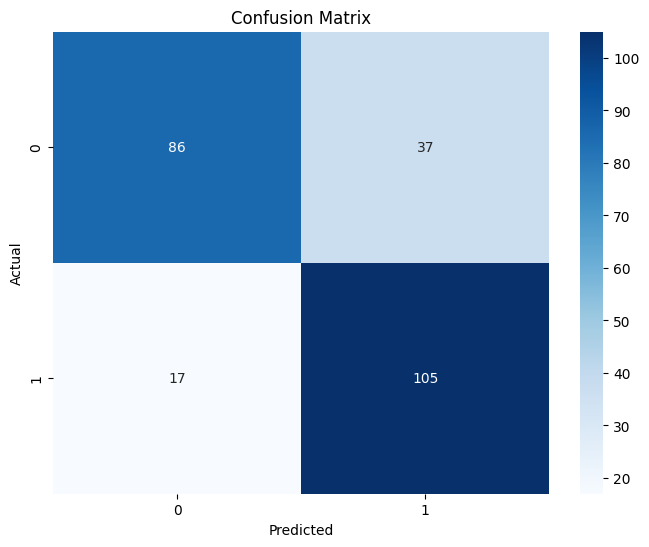

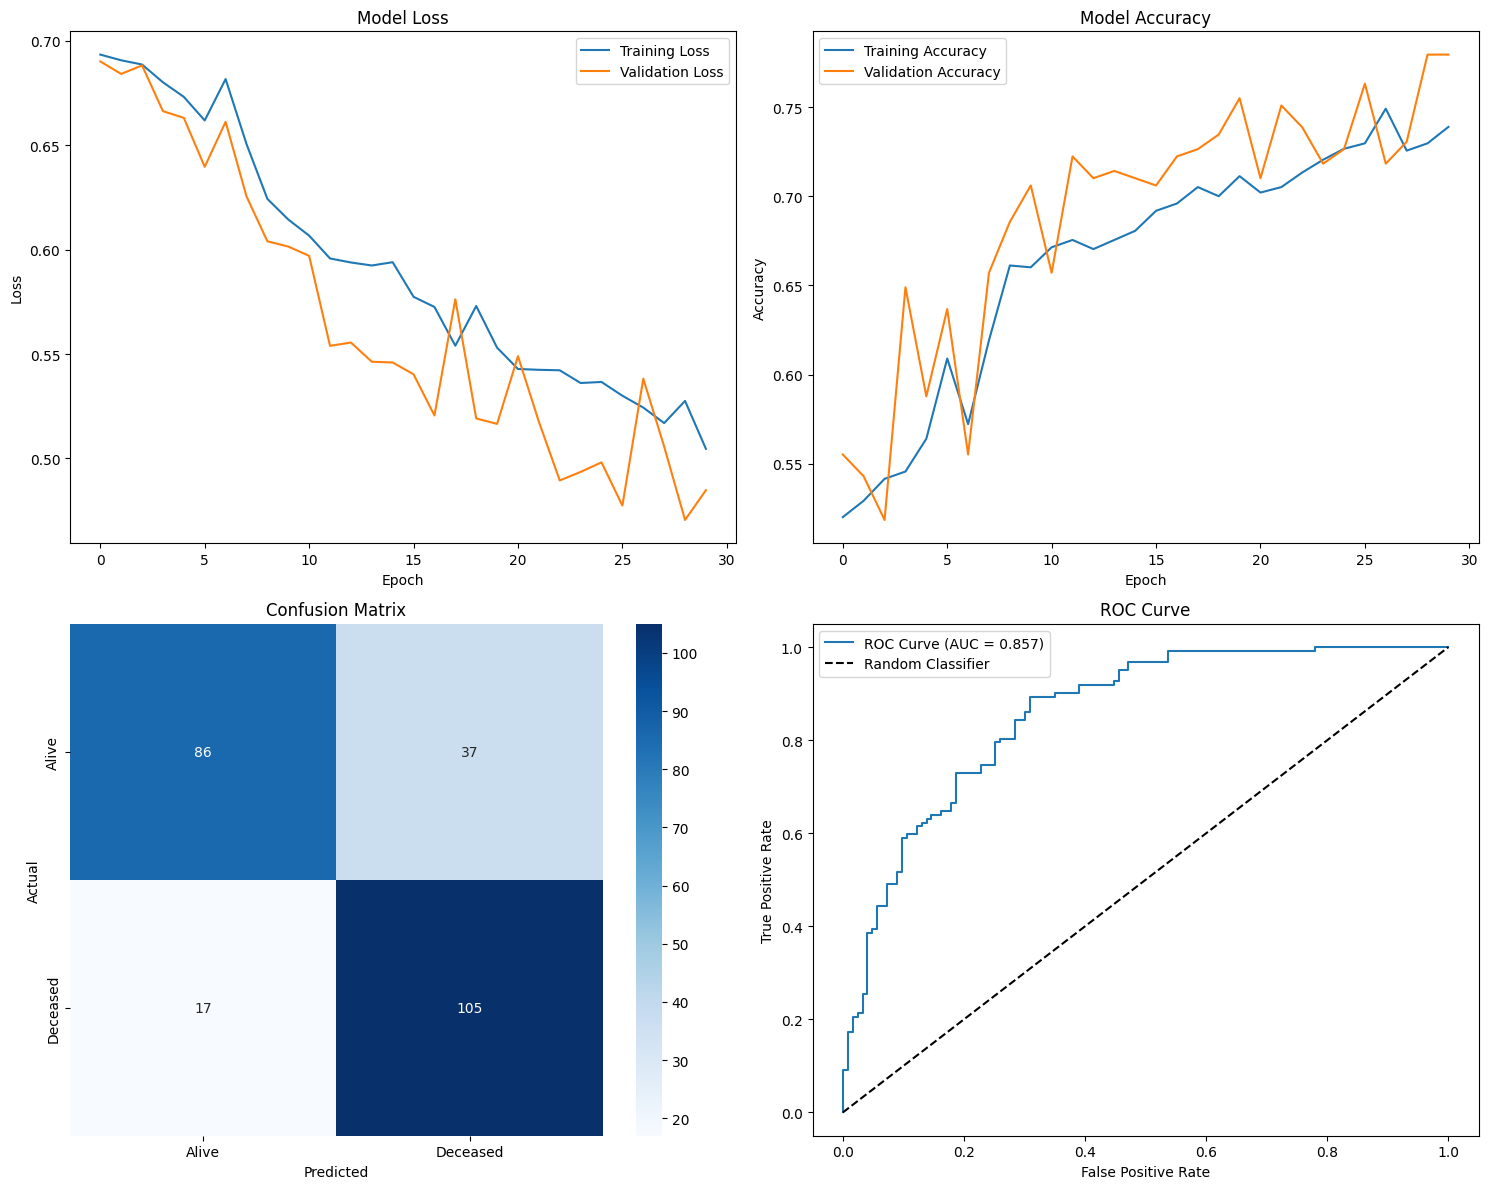

Final Test Accuracy: 0.7796


In [26]:
if has_labels:
    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.2, random_state=42, stratify=y
    )

    classifier = build_downstream_classifier(encoder, num_classes=2)
    downstream_history = train_downstream_classifier(
        classifier, X_train, y_train, adj_matrix, X_test, y_test, epochs=30
    )

    accuracy, y_pred_proba, y_pred = evaluate_model(
        classifier, X_test, adj_matrix, y_test
    )

    plot_downstream_results(downstream_history, y_test, y_pred_proba, y_pred)

    print(f"Final Test Accuracy: {accuracy:.4f}")
else:
    print("No labels available for downstream task.")
    encoder.save('pretrained_gnn_encoder.h5')